In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy.stats import norm
from matplotlib import pyplot as plt
import warnings

## Exercises

1. Construct the left model in Figure 16.2 (using precision
   $1/\sqrt{\tau}$) and generate Figure 16.3. 
   * Use a non noncommittal prior for $\tau$ with $\mathit{Sh} = 0.01$
     and $R = 0.01$.
   * _Hint_: Use a reference the right model of Figure 16.2 presented
     in this notebook.
     
2. Exercise 16.1
3. Exercise 16.2
4. Exercise 16.3

Precision is determined by a statistical method called a standard deviation. Standard deviation is how much, on average, measurements differ from each other. High standard deviations indicate low precision, low standard deviations indicate high precision.

In [4]:
# 1. Construct the left model in Figure 16.2

df = pd.read_csv('data/TwoGroupIQ.csv')
y = df[df.Group=='Smart Drug'].Score.to_numpy()

Ntotal  = len(y)
μy      = np.mean(y)
σy      = np.std(y)

with pm.Model() as normal_standard_gamma:
    τ = pm.Gamma('τ', alpha=0.01, beta=0.01)
    μ = pm.Normal('μ', mu=μy, sigma=100*σy)
    
    obs = pm.Normal('obs', mu=μ, tau=τ, observed=y)

    eff_size = pm.Deterministic('eff_size',(μ-100)/τ)

    trace = pm.sample(20000, chains=2, tune=1000, step=pm.Metropolis())

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [μ]
>Metropolis: [τ]
Sampling 2 chains, 0 divergences: 100%|██████████| 42000/42000 [00:14<00:00, 2862.90draws/s]
The number of effective samples is smaller than 25% for some parameters.


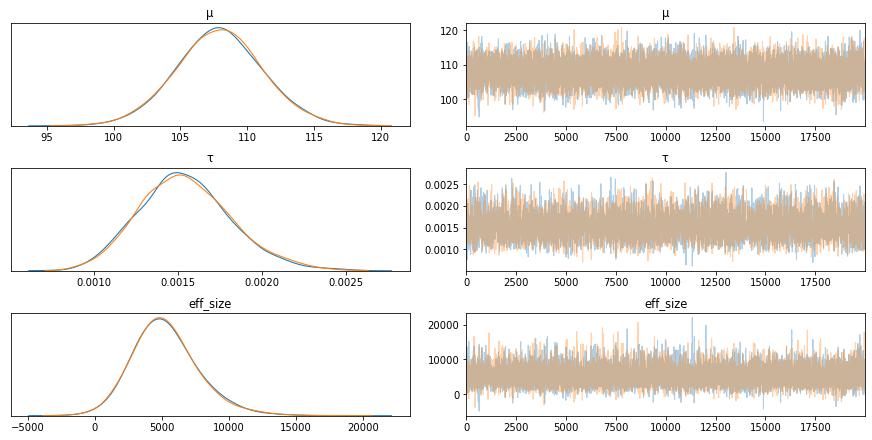

In [5]:
warnings.simplefilter('ignore', UserWarning)
pm.traceplot(trace); # , combined=True

In [6]:
# Auxiliary function to plot
def plot_hist_dens(init, end, y, trace, num_ppcs, ax):
    if num_ppcs > len(trace):
        print('num_ppcs is greater than the length of the trace. '+str(num_ppcs)+' > '+str(len(trace))+ '.')
        print('You must enter a number less or equal than the length of the trace.')
        return None
    X = np.linspace(init,end,(end-init)*10)  # Between any two points there are ten points (e.g., 0, 0.1, 0.2, ...)
    Y = lambda mu,sigma: [norm.pdf(x,loc=mu,scale=sigma) for x in X]
    [ax.plot(X,Y(s['μ'],s['σ']), color='lightsteelblue') for s in trace[len(trace)-num_ppcs:]]
#     weights = np.ones_like(y)/(len(y)*10)  # Rescale the histogram to look like in the figure
    ax.hist(y, bins=19, color="steelblue")
    ax.text(0.8, 0.8, r'$N='+str(len(y))+'$', transform=ax.transAxes, fontsize=12)

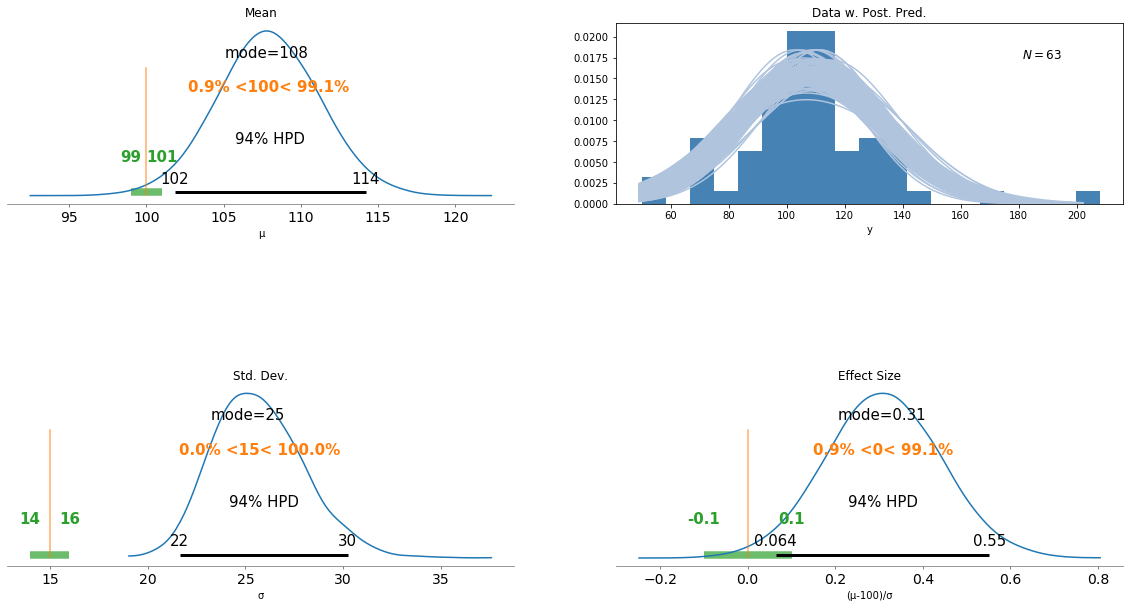

In [4]:
# Plotting Figure 16.3 left side

fig, axs = plt.subplots(nrows=2,ncols=2, figsize=(20,10))
pm.plot_posterior(trace['μ'], point_estimate='mode', ref_val=100, rope=(99,101), ax=axs[0,0])
plot_hist_dens(49,202,y,trace,250,axs[0,1])
pm.plot_posterior(trace['σ'], point_estimate='mode', ref_val=15, rope=(14,16), ax=axs[1,0])
pm.plot_posterior(trace['eff_size'], point_estimate='mode', ref_val=0, rope=(-0.1,0.1), ax=axs[1,1])
axs[0,0].set_title('Mean')
axs[0,0].set_xlabel('μ')
axs[0,1].set_title('Data w. Post. Pred.')
axs[0,1].set_xlabel('y')
axs[1,0].set_title('Std. Dev.')
axs[1,0].set_xlabel('σ')
axs[1,1].set_title('Effect Size')
axs[1,1].set_xlabel('(μ-100)/σ')
fig.subplots_adjust(hspace=1)
plt.show()

In [8]:
# Exercise 16.1 (A)
df_flies = pd.read_csv('data/ShohatOphirKAMH2012dataReduced.csv')

y = df_flies.PreferenceIndex.to_numpy()

μy = np.mean(y)
σy = np.std(y)

y_mat = df_flies[df_flies.Group == 'MatedGrouped'].PreferenceIndex
y_rej = df_flies[df_flies.Group == 'RejectedIsolated'].PreferenceIndex
y_joint=[y_mat, y_rej]

with pm.Model() as two_groups_fliesA:
    
    σ = pm.Uniform('σ',lower=σy/1000,upper=σy*1000,shape=2)
    μ = pm.Normal('μ',mu=μy,sigma=σy*100,shape=2)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    # 0: MatedGrouped
    # 1: RejectedIsolated
    [pm.StudentT('obs_'+str(i), nu=ν, mu=μ[i], sigma=σ[i], observed=y_joint[i]) for i in [0,1]]

    pm.Deterministic('log10_ν',np.log10(ν))
    pm.Deterministic('diff_μ', μ[1]-μ[0])
    pm.Deterministic('diff_σ', σ[1]-σ[0])
    pm.Deterministic('eff_size',(μ[1]-μ[0])/pm.math.sqrt((pm.math.sqr(σ[0])+pm.math.sqr(σ[1]))/2))    

    trace_two_groups_fliesA = pm.sample(20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, μ, σ]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [01:06<00:00, 611.98draws/s]
The acceptance probability does not match the target. It is 0.8894628252500756, but should be close to 0.8. Try to increase the number of tuning steps.


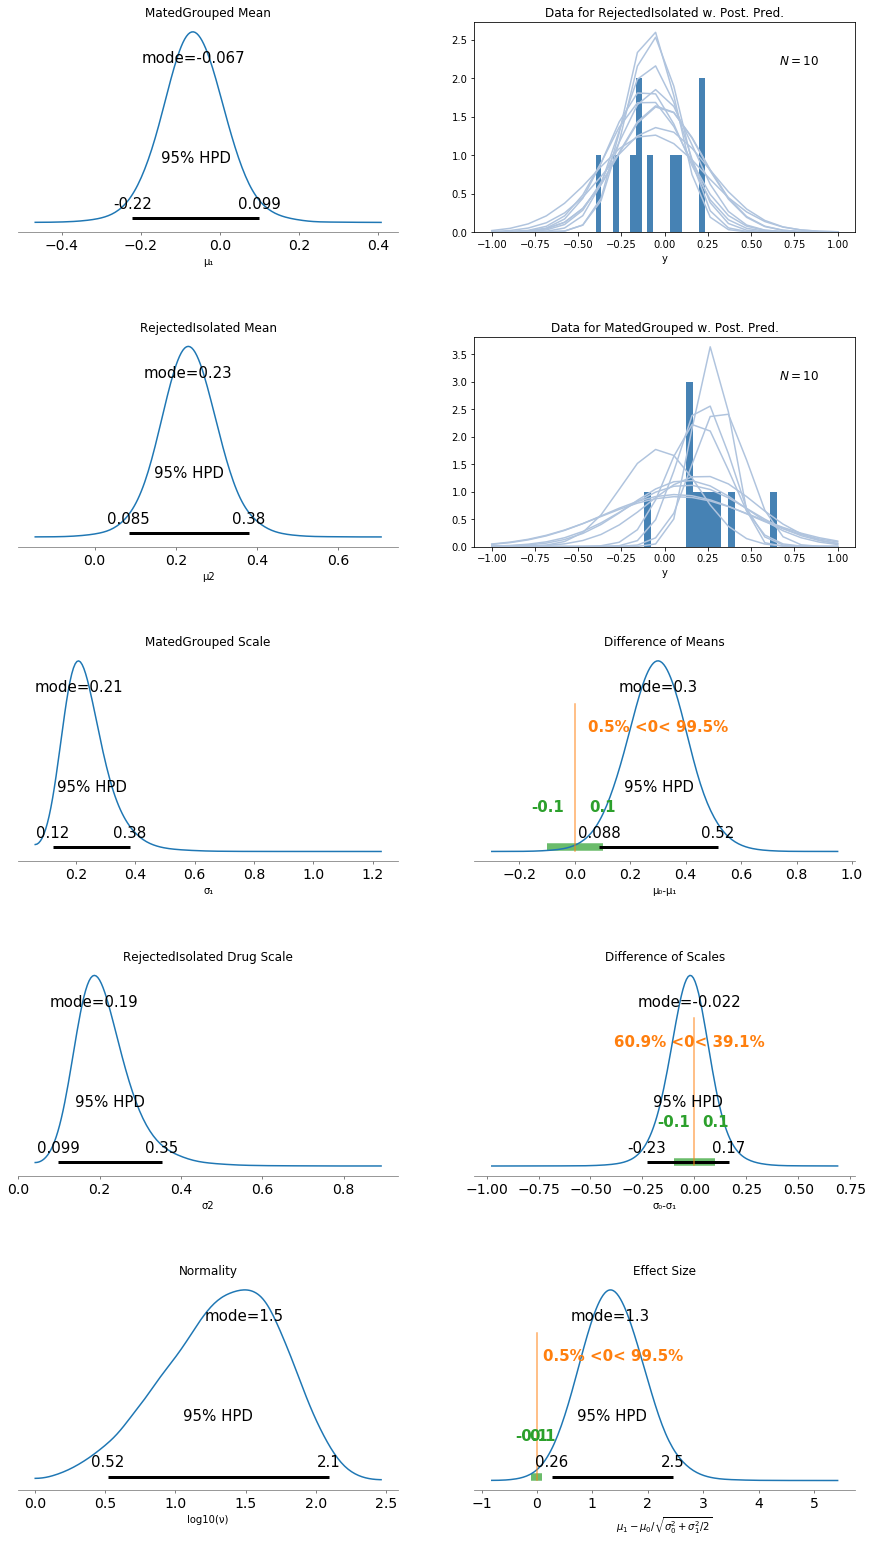

In [9]:
mat_μs = np.array([s[0] for s in trace_two_groups_fliesA['μ']])
mat_σs = np.array([s[0] for s in trace_two_groups_fliesA['σ']])

rej_μs = np.array([s[1] for s in trace_two_groups_fliesA['μ']])
rej_σs = np.array([s[1] for s in trace_two_groups_fliesA['σ']])

mat_trace = np.array([x for x in zip(mat_μs, mat_σs)], dtype=[('μ','f4'),('σ','f4')])

rej_trace = np.array([x for x in zip(rej_μs, rej_σs)], dtype=[('μ','f4'),('σ','f4')])


fig,axs = plt.subplots(nrows=5,ncols=2,figsize=(15,27))

pm.plot_posterior(mat_μs, ax=axs[0,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(rej_μs, ax=axs[1,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(mat_σs, ax=axs[2,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(rej_σs, ax=axs[3,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(trace_two_groups_fliesA['log10_ν'], ax=axs[4,0], point_estimate='mode', credible_interval=.95)

# TODO
# range of PreferenceIndex values. [-1, -1]
plot_hist_dens(-1,1, y_mat, mat_trace, 10, ax=axs[0,1])
plot_hist_dens(-1,1, y_rej, rej_trace, 10, ax=axs[1,1])

pm.plot_posterior(trace_two_groups_fliesA['diff_μ'], ax=axs[2,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)

pm.plot_posterior(trace_two_groups_fliesA['diff_σ'], ax=axs[3,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)

pm.plot_posterior(trace_two_groups_fliesA['eff_size'], ax=axs[4,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)


fig.subplots_adjust(hspace=0.5)

axs[0,0].set_title('MatedGrouped Mean')
axs[0,0].set_xlabel('μ₁')
axs[1,0].set_title('RejectedIsolated Mean')
axs[1,0].set_xlabel('μ2')

axs[2,0].set_title('MatedGrouped Scale')
axs[2,0].set_xlabel('σ₁')
axs[3,0].set_title('RejectedIsolated Drug Scale')
axs[3,0].set_xlabel('σ2')

axs[4,0].set_title('Normality')
axs[4,0].set_xlabel('log10(ν)')

axs[0,1].set_title('Data for RejectedIsolated w. Post. Pred.')
axs[0,1].set_xlabel('y')

axs[1,1].set_title('Data for MatedGrouped w. Post. Pred.')
axs[1,1].set_xlabel('y')

axs[2,1].set_title('Difference of Means')
axs[2,1].set_xlabel('μ₀-μ₁')

axs[3,1].set_title('Difference of Scales')
axs[3,1].set_xlabel('σ₀-σ₁')

axs[4,1].set_title('Effect Size')
axs[4,1].set_xlabel('$\mu_1-\mu_0/\sqrt{ \sigma^2_0 + \sigma^2_1 / 2}$');

The resulting posterior is summarized in the figure below. The difference of means has a modal
value near 0.3. The 95% HDI clearly excludes zero, but not the arbitrary ROPE of -0.1 to +0.1.
On the other hand, the effect size has a mode of about 1.3 (which is big) and a 95% HDI that
clearly excludes a ROPE from -0.1 to 0.1, which is a typical limit (in psychological research) for
a “small” effect size. In other words, the difference between groups is fairly large compared to
the uncertainty of the estimate. (The difference between scales, on the other hand, is nearly
zero.) In other words, the rejected males preferred the alcohol more than the mated males.

In [7]:
# Exercise 16.1 (B)

y = df_flies.GrandTotal.to_numpy()

μy = np.mean(y)
σy = np.std(y)

y_mat = df_flies[df_flies.Group == 'MatedGrouped'].GrandTotal
y_rej = df_flies[df_flies.Group == 'RejectedIsolated'].GrandTotal
y_joint=[y_mat, y_rej]

with pm.Model() as two_groups_fliesB:
    
    σ = pm.Uniform('σ',lower=σy/1000,upper=σy*1000,shape=2)
    μ = pm.Normal('μ',mu=μy,sigma=σy*100,shape=2)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    # 0: MatedGrouped
    # 1: RejectedIsolated
    [pm.StudentT('obs_'+str(i), nu=ν, mu=μ[i], sigma=σ[i], observed=y_joint[i]) for i in [0,1]]

    pm.Deterministic('log10_ν',np.log10(ν))
    pm.Deterministic('diff_μ', μ[1]-μ[0])
    pm.Deterministic('diff_σ', σ[1]-σ[0])
    pm.Deterministic('eff_size',(μ[1]-μ[0])/pm.math.sqrt((pm.math.sqr(σ[0])+pm.math.sqr(σ[1]))/2))    

    trace_two_groups_fliesB = pm.sample(20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [ν_minus_one, μ, σ]
Sampling 2 chains, 0 divergences: 100%|██████████| 41000/41000 [00:47<00:00, 854.36draws/s] 
The acceptance probability does not match the target. It is 0.6553556469313303, but should be close to 0.8. Try to increase the number of tuning steps.


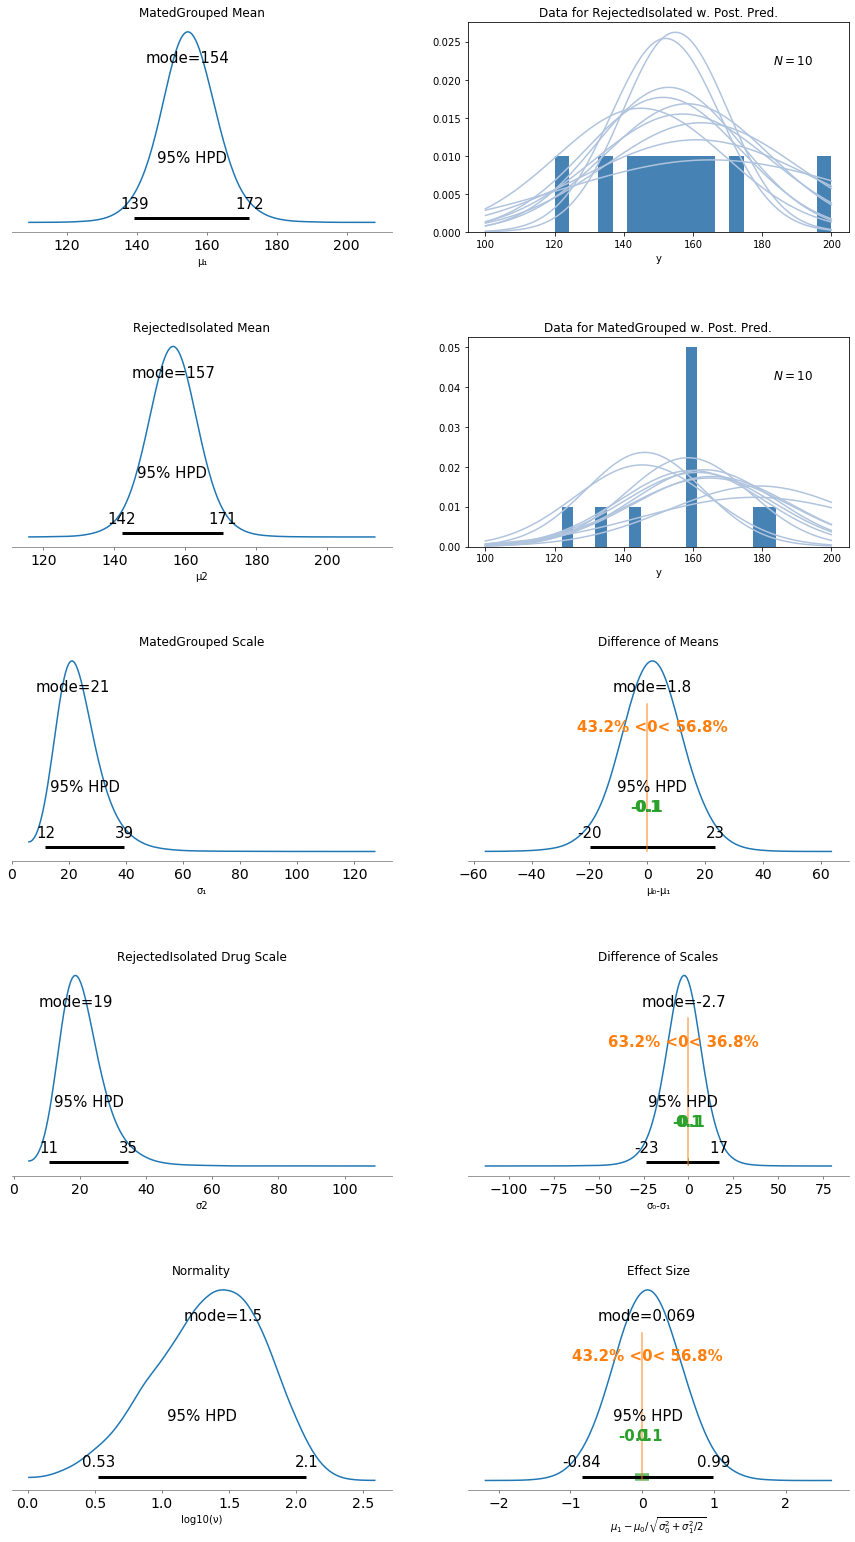

In [8]:
mat_μs = np.array([s[0] for s in trace_two_groups_fliesB['μ']])
mat_σs = np.array([s[0] for s in trace_two_groups_fliesB['σ']])

rej_μs = np.array([s[1] for s in trace_two_groups_fliesB['μ']])
rej_σs = np.array([s[1] for s in trace_two_groups_fliesB['σ']])

mat_trace = np.array([x for x in zip(mat_μs, mat_σs)], dtype=[('μ','f4'),('σ','f4')])

rej_trace = np.array([x for x in zip(rej_μs, rej_σs)], dtype=[('μ','f4'),('σ','f4')])


fig,axs = plt.subplots(nrows=5,ncols=2,figsize=(15,27))

pm.plot_posterior(mat_μs, ax=axs[0,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(rej_μs, ax=axs[1,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(mat_σs, ax=axs[2,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(rej_σs, ax=axs[3,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(trace_two_groups_fliesB['log10_ν'], ax=axs[4,0], point_estimate='mode', credible_interval=.95)

# range of GrandTotal values. [100, 200]
plot_hist_dens(100,200, y_mat, mat_trace, 10, ax=axs[0,1])
plot_hist_dens(100,200, y_rej, rej_trace, 10, ax=axs[1,1])

pm.plot_posterior(trace_two_groups_fliesB['diff_μ'], ax=axs[2,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)

pm.plot_posterior(trace_two_groups_fliesB['diff_σ'], ax=axs[3,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)

pm.plot_posterior(trace_two_groups_fliesB['eff_size'], ax=axs[4,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)


fig.subplots_adjust(hspace=0.5)

axs[0,0].set_title('MatedGrouped Mean')
axs[0,0].set_xlabel('μ₁')
axs[1,0].set_title('RejectedIsolated Mean')
axs[1,0].set_xlabel('μ2')

axs[2,0].set_title('MatedGrouped Scale')
axs[2,0].set_xlabel('σ₁')
axs[3,0].set_title('RejectedIsolated Drug Scale')
axs[3,0].set_xlabel('σ2')

axs[4,0].set_title('Normality')
axs[4,0].set_xlabel('log10(ν)')

axs[0,1].set_title('Data for RejectedIsolated w. Post. Pred.')
axs[0,1].set_xlabel('y')

axs[1,1].set_title('Data for MatedGrouped w. Post. Pred.')
axs[1,1].set_xlabel('y')

axs[2,1].set_title('Difference of Means')
axs[2,1].set_xlabel('μ₀-μ₁')

axs[3,1].set_title('Difference of Scales')
axs[3,1].set_xlabel('σ₀-σ₁')

axs[4,1].set_title('Effect Size')
axs[4,1].set_xlabel('$\mu_1-\mu_0/\sqrt{ \sigma^2_0 + \sigma^2_1 / 2}$');

The effect size has a modal value of about 0.14, and a 95% HDI that extends from -0.84 to
+1.0. Clearly there is no notable difference between the groups in terms of total consumption,
and we would not reject a difference of zero. But also we would not accept a difference of
zero because the estimate is very uncertain. These results do, however, demonstrate that we
cannot attribute the difference in relative alcohol consumption (shown in the previous part) to a
difference in overall consumption.

Exercise 16.2. [Purpose: More practice using different data files in the high-level
script, using a real example, with skewed data.] The typical lifespan of a laboratory
rat that eats ad lib is approximately 700 days. When rats are placed on a restricted diet, their
longevity can increase, but there is a lot of variability in lifespans across different individual
rats. Restricting the diet might not only affect the typical lifespan, but restricting the diet
might also affect the variance of the lifespan across rats. We consider data from R. L. Berger,
Boos, and Guess (1988), as reported in Hand, Daly, Lunn, McConway, and Ostrowski (1994,
data set #242), and which are available in the file named RatLives.csv .

(A) Run the two-group analysis on the rat longevity data. Use JAGS or Stan as you
prefer (report which one you used). Report the code you used to read in the data file,
specify the column names for the data, and the ROPEs appropriate to the scale of the
data. Do the groups appear to differ in their central tendencies and variances? Does the
value of the normality parameter suggest that the data have outliers relative to a normal
distribution?

(B) The data within each group appear to be skewed to the left. That is, within each
group, there are many rats that died relatively young, but there are fewer outliers on the high
end. We could try to implement a skewed noise distribution, or we could try to transform
the data so they are approximately symmetric within each group. We will try the latter
approach here. To get rid of leftward skew, we need a transformation that expands the
rightward values. We will try squaring the data. Read in the data and append a transformed
data column like this:

myDataFrame = read.csv( file="RatLives.csv" ) <br>
myDataFrame = cbind( myDataFrame , DaysLiveSq = myDataFrame$ DaysLiveˆ2 ) <br>
yName="DaysLiveSq"

Change the specification of the ROPEs to be appropriate to the transformed data. Do the
groups appear to differ in their central tendencies and variances on the days-squared scale?

In [9]:
# Exercise 16.2 (A)
df_rat = pd.read_csv('data/RatLives.csv')

y = df_rat.DaysLive.to_numpy()

μy = np.mean(y)
σy = np.std(y)

y_adlib = df_rat[df_rat.Group == 'Adlib'].DaysLive
y_Restrict = df_rat[df_rat.Group == 'Restrict'].DaysLive
y_joint=[y_adlib, y_Restrict]

with pm.Model() as two_groups_ratA:
    
    σ = pm.Uniform('σ',lower=σy/1000,upper=σy*1000,shape=2)
    μ = pm.Normal('μ',mu=μy,sigma=σy*100,shape=2)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    # 0: adlib
    # 1: Restrict
    [pm.StudentT('obs_'+str(i), nu=ν, mu=μ[i], sigma=σ[i], observed=y_joint[i]) for i in [0,1]]

    pm.Deterministic('log10_ν',np.log10(ν))
    pm.Deterministic('diff_μ', μ[1]-μ[0])
    pm.Deterministic('diff_σ', σ[1]-σ[0])
    pm.Deterministic('eff_size',(μ[1]-μ[0])/pm.math.sqrt((pm.math.sqr(σ[0])+pm.math.sqr(σ[1]))/2))    

    trace_two_groups_ratA = pm.sample(20000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, μ, σ]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [01:30<00:00, 910.32draws/s] 


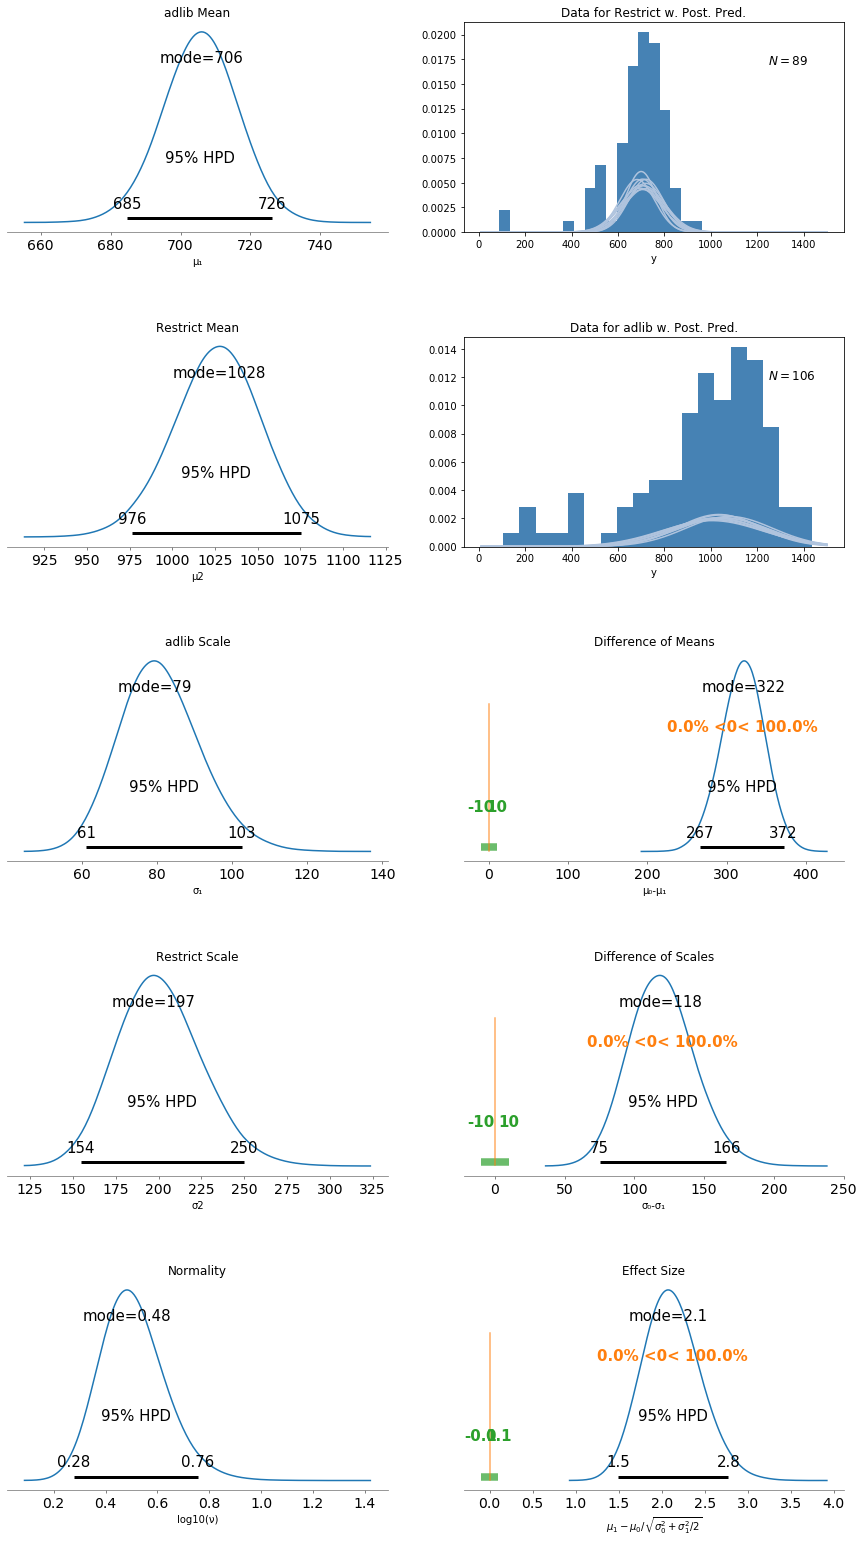

In [10]:
adlib_μs = np.array([s[0] for s in trace_two_groups_ratA['μ']])
adlib_σs = np.array([s[0] for s in trace_two_groups_ratA['σ']])

Restrict_μs = np.array([s[1] for s in trace_two_groups_ratA['μ']])
Restrict_σs = np.array([s[1] for s in trace_two_groups_ratA['σ']])

adlib_trace = np.array([x for x in zip(adlib_μs, adlib_σs)], dtype=[('μ','f4'),('σ','f4')])

Restrict_trace = np.array([x for x in zip(Restrict_μs, Restrict_σs)], dtype=[('μ','f4'),('σ','f4')])


fig,axs = plt.subplots(nrows=5,ncols=2,figsize=(15,27))

pm.plot_posterior(adlib_μs, ax=axs[0,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(Restrict_μs, ax=axs[1,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(adlib_σs, ax=axs[2,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(Restrict_σs, ax=axs[3,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(trace_two_groups_ratA['log10_ν'], ax=axs[4,0], point_estimate='mode', credible_interval=.95)

# range of Dayslive values. [10, 1500]
plot_hist_dens(10,1500, y_adlib, adlib_trace, 10, ax=axs[0,1])
plot_hist_dens(10,1500, y_Restrict, Restrict_trace, 10, ax=axs[1,1])

pm.plot_posterior(trace_two_groups_ratA['diff_μ'], ax=axs[2,1], point_estimate='mode',
                  ref_val=0, rope=(-10,10), credible_interval=.95)

pm.plot_posterior(trace_two_groups_ratA['diff_σ'], ax=axs[3,1], point_estimate='mode',
                  ref_val=0, rope=(-10,10), credible_interval=.95)

pm.plot_posterior(trace_two_groups_ratA['eff_size'], ax=axs[4,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)


fig.subplots_adjust(hspace=0.5)

axs[0,0].set_title('adlib Mean')
axs[0,0].set_xlabel('μ₁')
axs[1,0].set_title('Restrict Mean')
axs[1,0].set_xlabel('μ2')

axs[2,0].set_title('adlib Scale')
axs[2,0].set_xlabel('σ₁')
axs[3,0].set_title('Restrict Scale')
axs[3,0].set_xlabel('σ2')

axs[4,0].set_title('Normality')
axs[4,0].set_xlabel('log10(ν)')

axs[0,1].set_title('Data for Restrict w. Post. Pred.')
axs[0,1].set_xlabel('y')

axs[1,1].set_title('Data for adlib w. Post. Pred.')
axs[1,1].set_xlabel('y')

axs[2,1].set_title('Difference of Means')
axs[2,1].set_xlabel('μ₀-μ₁')

axs[3,1].set_title('Difference of Scales')
axs[3,1].set_xlabel('σ₀-σ₁')

axs[4,1].set_title('Effect Size')
axs[4,1].set_xlabel('$\mu_1-\mu_0/\sqrt{ \sigma^2_0 + \sigma^2_1 / 2}$');

The ROPEs on mu and sigma were set to c(-10,+10) because a 10 day difference in longevity
seems intuitively like a noticeable difference, for typical lifespan of 700 days. The ROPE on
effect size was set to c(-0.1,+0.1) because 0.1 is conventionally a “small” effect size.
The result is shown above. There is a very strong difference between groups both in
means (mu) and in scales (sigma). The restricted diet group lives about 322 days longer on
average, but also has a scale (sigma) about 117 days bigger. The normality parameter is very
small, indicating that the data have large, non-normal tails. Visual inspection of the data
suggests that the left tail is heavy.

In [11]:
# Exercise 16.2 (B)

df_rat['DaysLive'] = df_rat['DaysLive']**2

y = df_rat.DaysLive.to_numpy()

μy = np.mean(y)
σy = np.std(y)

y_adlib = df_rat[df_rat.Group == 'Adlib'].DaysLive
y_Restrict = df_rat[df_rat.Group == 'Restrict'].DaysLive
y_joint=[y_adlib, y_Restrict]

with pm.Model() as two_groups_ratB:
    
    σ = pm.Uniform('σ',lower=σy/1000,upper=σy*1000,shape=2)
    μ = pm.Normal('μ',mu=μy,sigma=σy*100,shape=2)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    # 0: adlib
    # 1: Restrict
    [pm.StudentT('obs_'+str(i), nu=ν, mu=μ[i], sigma=σ[i], observed=y_joint[i]) for i in [0,1]]

    pm.Deterministic('log10_ν',np.log10(ν))
    pm.Deterministic('diff_μ', μ[1]-μ[0])
    pm.Deterministic('diff_σ', σ[1]-σ[0])
    pm.Deterministic('eff_size',(μ[1]-μ[0])/pm.math.sqrt((pm.math.sqr(σ[0])+pm.math.sqr(σ[1]))/2))    

    trace_two_groups_ratB = pm.sample(20000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, μ, σ]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [01:34<00:00, 866.61draws/s] 


In [12]:
# df_rat['DaysLive'].iloc[:].plot(kind='bar')

KeyboardInterrupt: 

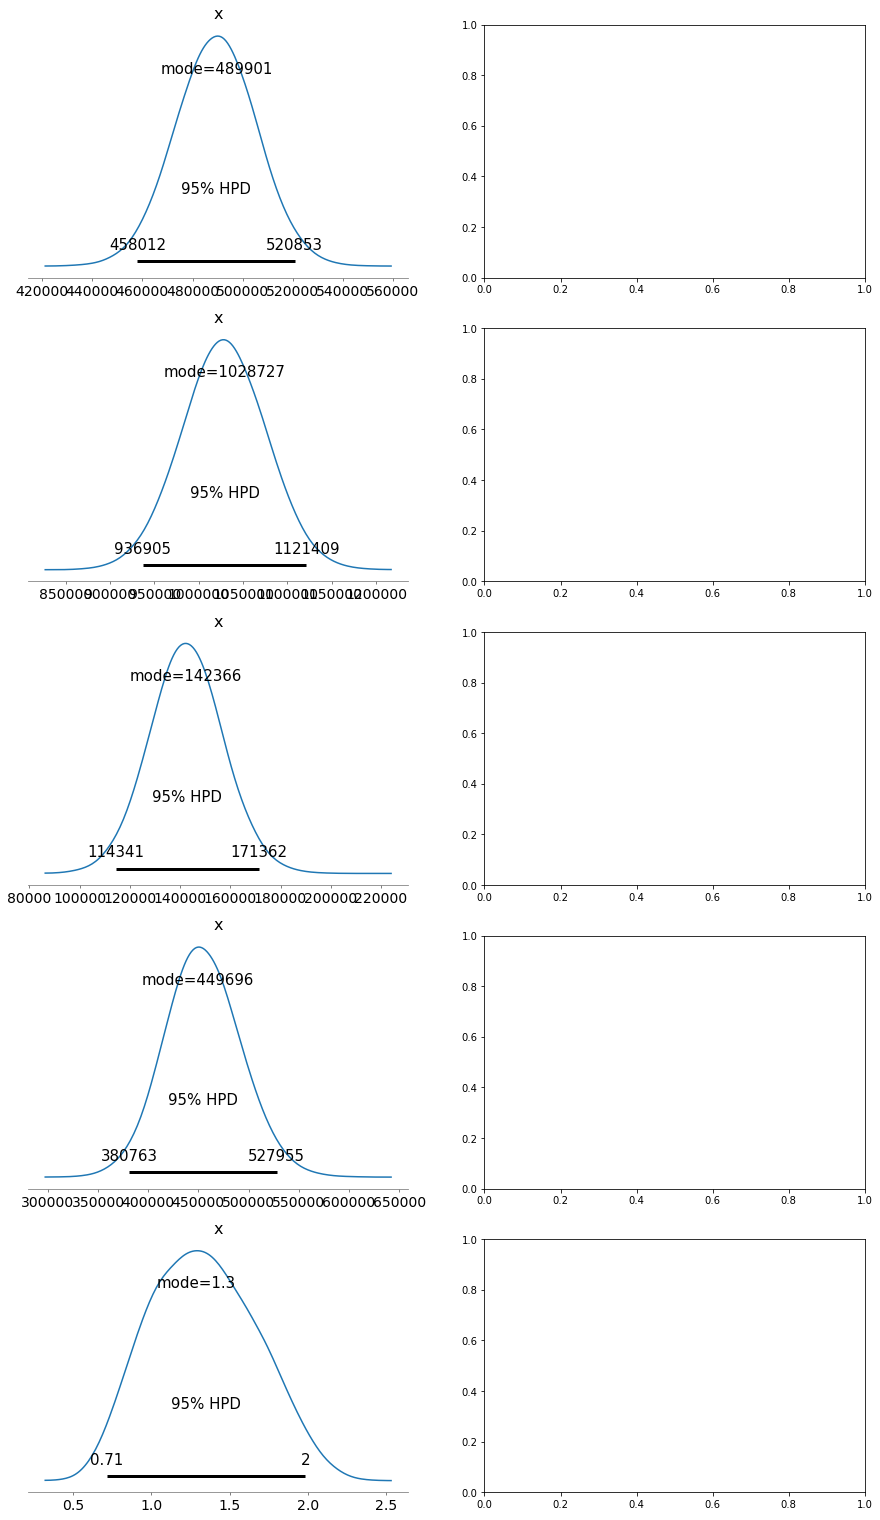

In [13]:
adlib_μs = np.array([s[0] for s in trace_two_groups_ratB['μ']])
adlib_σs = np.array([s[0] for s in trace_two_groups_ratB['σ']])

Restrict_μs = np.array([s[1] for s in trace_two_groups_ratB['μ']])
Restrict_σs = np.array([s[1] for s in trace_two_groups_ratB['σ']])

adlib_trace = np.array([x for x in zip(adlib_μs, adlib_σs)], dtype=[('μ','f4'),('σ','f4')])

Restrict_trace = np.array([x for x in zip(Restrict_μs, Restrict_σs)], dtype=[('μ','f4'),('σ','f4')])


fig,axs = plt.subplots(nrows=5,ncols=2,figsize=(15,27))

pm.plot_posterior(adlib_μs, ax=axs[0,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(Restrict_μs, ax=axs[1,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(adlib_σs, ax=axs[2,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(Restrict_σs, ax=axs[3,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(trace_two_groups_ratB['log10_ν'], ax=axs[4,0], point_estimate='mode', credible_interval=.95)

# range of Dayslive values. [10, 1500]
plot_hist_dens(100,2250000, y_adlib, adlib_trace, 10, ax=axs[0,1])
plot_hist_dens(100,2250000, y_Restrict, Restrict_trace, 10, ax=axs[1,1])

pm.plot_posterior(trace_two_groups_ratB['diff_μ'], ax=axs[2,1], point_estimate='mode',
                  ref_val=0, rope=(-100,100), credible_interval=.95)

pm.plot_posterior(trace_two_groups_ratB['diff_σ'], ax=axs[3,1], point_estimate='mode',
                  ref_val=0, rope=(-100,100), credible_interval=.95)

pm.plot_posterior(trace_two_groups_ratB['eff_size'], ax=axs[4,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)


fig.subplots_adjust(hspace=0.5)

axs[0,0].set_title('adlib Mean')
axs[0,0].set_xlabel('μ₁')
axs[1,0].set_title('Restrict Mean')
axs[1,0].set_xlabel('μ2')

axs[2,0].set_title('adlib Scale')
axs[2,0].set_xlabel('σ₁')
axs[3,0].set_title('Restrict Scale')
axs[3,0].set_xlabel('σ2')

axs[4,0].set_title('Normality')
axs[4,0].set_xlabel('log10(ν)')

axs[0,1].set_title('Data for Restrict w. Post. Pred.')
axs[0,1].set_xlabel('y')

axs[1,1].set_title('Data for adlib w. Post. Pred.')
axs[1,1].set_xlabel('y')

axs[2,1].set_title('Difference of Means')
axs[2,1].set_xlabel('μ₀-μ₁')

axs[3,1].set_title('Difference of Scales')
axs[3,1].set_xlabel('σ₀-σ₁')

axs[4,1].set_title('Effect Size')
axs[4,1].set_xlabel('$\mu_1-\mu_0/\sqrt{ \sigma^2_0 + \sigma^2_1 / 2}$');

The ROPEs on mu and sigma were set to c(-10^2,+10^2) to be consistent with the previous
part of the exercise. That is, because the data were squared, the ROPE limits were squared.
The ROPE on the effect size, however, stayed the same, because the effect size is already
standardized (i.e., divided by the scale of the data).
Results are shown above. The differences of mu and sigma are clearly large and non-zero. The
effect size is also quite large and non-zero, although on the squared-data the modal effect size
is only about 1.6 while on the original data the modal effect size was about 2.1. The normality
parameter is much larger than when using the original data, and the squared data appear to be
reasonably normally distributed.
In this case, the parameters on the original scale are more directly interpretable, but the model
predicts symmetric data distributions. When using the squared scale, the parameter values can
only be interpreted on that scale, but the data are more nearly symmetric within groups.

Exercise 16.3. [Purpose: For two groups, examine the implied prior on the effect
size and on the differences of means and scales.]<br>
(A) Modify the script Stan-Ymet-Xnom2grp-MrobustHet-Example.R and functions
in Stan-Ymet-Xnom2grp-MrobustHet.R as needed to display the prior distribution. See
Section 14.3.4, p. 412, for details. Explain what changes you made, and include the graphical
output. Does Stan have convergence problems?<br>
(B) Modify the JAGS version of the program to sample from the prior. Refer to
Section 8.5, p. 211, for a reminder of how to sample from the prior in JAGS.
(C) From the previous two parts, is the prior on the effect size and differences suitably
“noncommittal”? Briefly discuss.

In [22]:
# Exercise 16.3 (A)
df = pd.read_csv('data/TwoGroupIQ.csv')
y_SmartDrug = df[df.Group=='Smart Drug'].Score.to_numpy()
y_Placebo = df[df.Group=='Placebo'].Score.to_numpy()

Ntotal  = len(y)
μy      = np.mean(y)
σy      = np.std(y)
with pm.Model() as two_groups_prior:
    
    σ = pm.Uniform('σ',lower=σy/1000,upper=σy*1000,shape=2)
    μ = pm.Normal('μ',mu=μy,sigma=σy*100,shape=2)
    ν_minus_one = pm.Exponential('ν_minus_one',lam=1/29)
    ν = pm.Deterministic('ν',ν_minus_one+1)

    # 0: adlib
    # 1: Restrict
#     [pm.StudentT('obs_'+str(i), nu=ν, mu=μ[i], sigma=σ[i], observed=y_joint[i]) for i in [0,1]]

    pm.Deterministic('log10_ν',np.log10(ν))
    pm.Deterministic('diff_μ', μ[1]-μ[0])
    pm.Deterministic('diff_σ', σ[1]-σ[0])
    pm.Deterministic('eff_size',(μ[1]-μ[0])/pm.math.sqrt((pm.math.sqr(σ[0])+pm.math.sqr(σ[1]))/2))    

In [23]:
with two_groups_prior:
    trace_two_groups_priorA = pm.sample(20000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, μ, σ]
Sampling 4 chains, 1 divergences: 100%|██████████| 82000/82000 [01:02<00:00, 1308.70draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [72]:
trace_two_groups_priorA['μ'][:, 0].shape

(80000,)

In [30]:
pm.summary(trace_two_groups_priorA)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],123.619,2512.814,-4578.895,4854.604,8.660,8.499,84197.0,43709.0,84169.0,62025.0,1.0
μ[1],98.875,2518.430,-4593.644,4884.055,9.020,8.719,77956.0,41720.0,77978.0,60251.0,1.0
σ[0],12574.502,7281.075,100.418,23771.124,26.345,19.329,76385.0,70950.0,68327.0,47972.0,1.0
σ[1],12597.634,7300.552,30.544,23783.956,26.068,19.139,78431.0,72749.0,72061.0,48156.0,1.0
ν_minus_one,29.369,28.965,0.002,81.702,0.103,0.079,78405.0,67714.0,55803.0,33863.0,1.0
ν,30.369,28.965,1.002,82.702,0.103,0.079,78405.0,67919.0,55803.0,33863.0,1.0
log10_ν,1.280,0.459,0.385,2.086,0.002,0.001,49876.0,49876.0,55803.0,33863.0,1.0
diff_μ,-24.745,3571.354,-6615.265,6765.756,12.567,12.362,80763.0,41733.0,80763.0,61408.0,1.0
diff_σ,23.131,10301.662,-18787.149,19378.776,37.930,34.690,73766.0,44094.0,73184.0,59986.0,1.0
eff_size,-0.005,0.632,-0.740,0.706,0.002,0.002,68641.0,68641.0,75054.0,60963.0,1.0


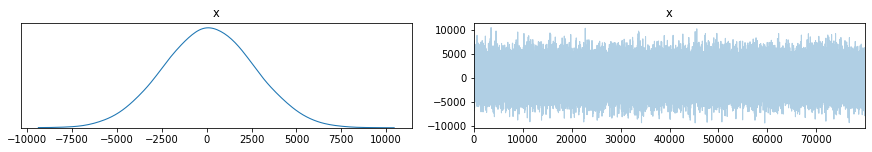

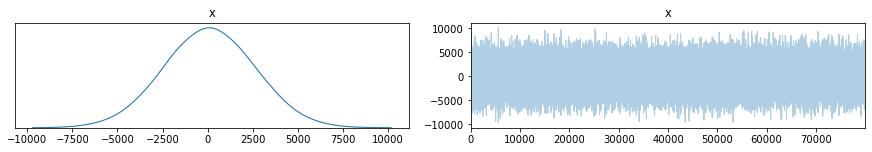

In [78]:
import warnings
warnings.simplefilter('ignore', UserWarning)
# d = trace_two_groups_priorA['μ'][0] ['μ'][:, 0]
pm.traceplot(trace_two_groups_priorA['μ'][:, 0])
pm.traceplot(trace_two_groups_priorA['μ'][:, 1]);


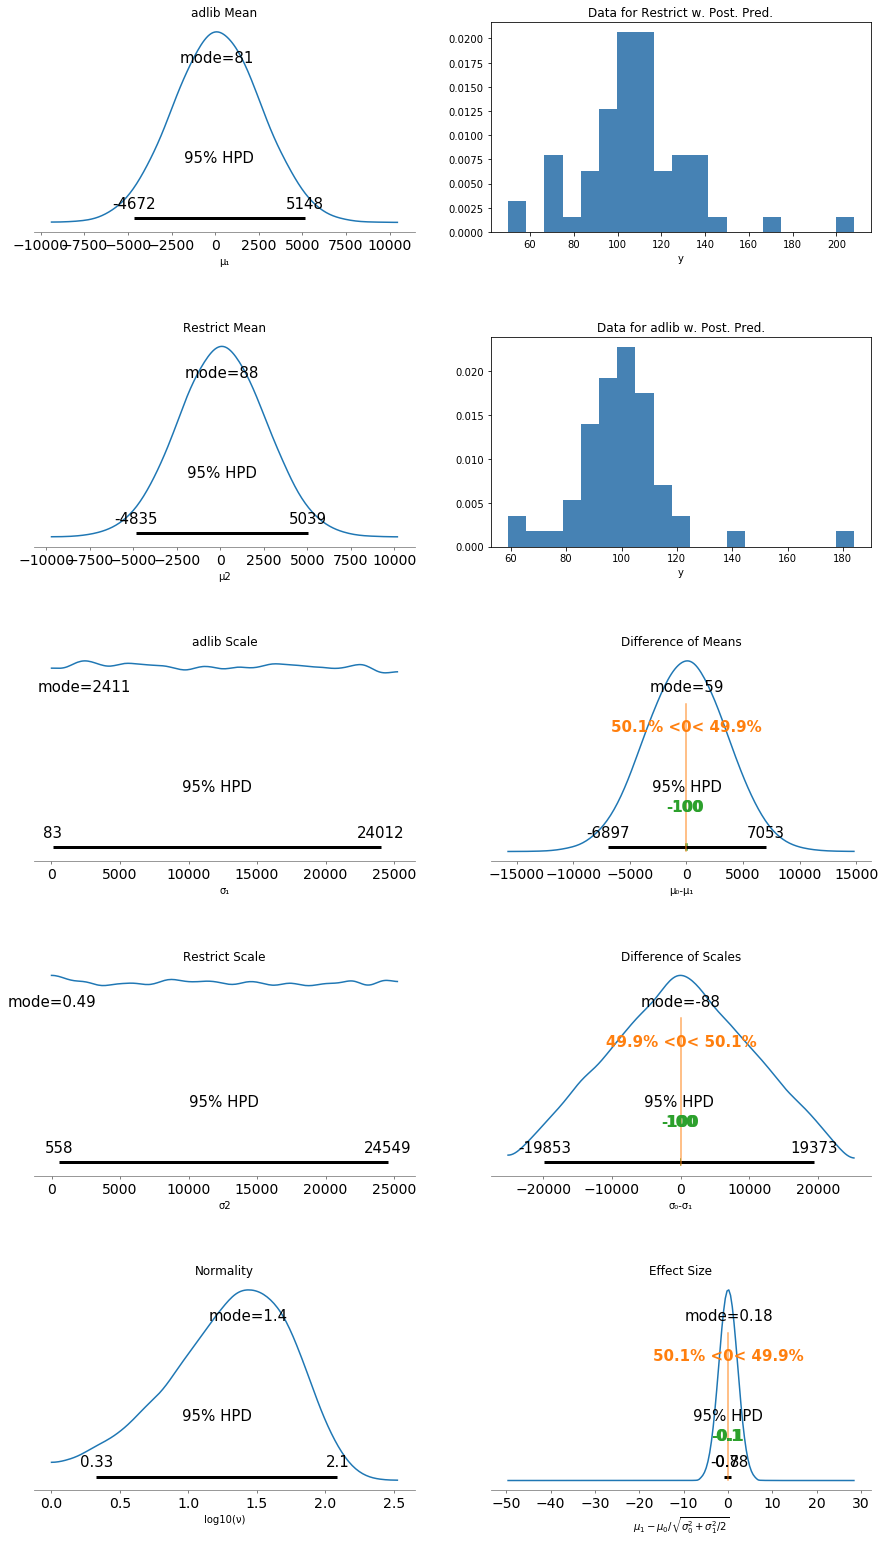

In [26]:
μs11 = np.array([s[0] for s in trace_two_groups_priorA['μ']])
σs12 = np.array([s[0] for s in trace_two_groups_priorA['σ']])

μs21 = np.array([s[1] for s in trace_two_groups_priorA['μ']])
σs22 = np.array([s[1] for s in trace_two_groups_priorA['σ']])

trace1 = np.array([x for x in zip(μs11, σs12)], dtype=[('μ','f4'),('σ','f4')])

trace2 = np.array([x for x in zip(μs21, σs22)], dtype=[('μ','f4'),('σ','f4')])


fig,axs = plt.subplots(nrows=5,ncols=2,figsize=(15,27))

pm.plot_posterior(μs11, ax=axs[0,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(μs21, ax=axs[1,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(σs12, ax=axs[2,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(σs22, ax=axs[3,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(trace_two_groups_priorA['log10_ν'], ax=axs[4,0], point_estimate='mode', credible_interval=.95)

weights_S = np.ones_like(y_SmartDrug)/(len(y_SmartDrug)*10)  # Rescale the histogram to look like in the figure
weights_P = np.ones_like(y_Placebo)/(len(y_Placebo)*10)  # Rescale the histogram to look like in the figure
axs[0,1].hist(y_SmartDrug, bins=19, weights=weights_S, color="steelblue")
axs[1,1].hist(y_Placebo, bins=19, weights=weights_P, color="steelblue")


# X = np.linspace(0,200,(200-0)*10)
# Y = lambda mu,sigma: [norm.pdf(x,loc=mu,scale=sigma) for x in X]
# [axs[0,1].plot(X,Y(s['μ'],s['σ']), color='lightsteelblue') for s in trace1[10:]]

pm.plot_posterior(trace_two_groups_priorA['diff_μ'], ax=axs[2,1], point_estimate='mode',
                  ref_val=0, rope=(-100,100), credible_interval=.95)

pm.plot_posterior(trace_two_groups_priorA['diff_σ'], ax=axs[3,1], point_estimate='mode',
                  ref_val=0, rope=(-100,100), credible_interval=.95)

pm.plot_posterior(trace_two_groups_priorA['eff_size'], ax=axs[4,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)




fig.subplots_adjust(hspace=0.5)

axs[0,0].set_title('adlib Mean')
axs[0,0].set_xlabel('μ₁')
axs[1,0].set_title('Restrict Mean')
axs[1,0].set_xlabel('μ2')

axs[2,0].set_title('adlib Scale')
axs[2,0].set_xlabel('σ₁')
axs[3,0].set_title('Restrict Scale')
axs[3,0].set_xlabel('σ2')

axs[4,0].set_title('Normality')
axs[4,0].set_xlabel('log10(ν)')

axs[0,1].set_title('Data for Restrict w. Post. Pred.')
axs[0,1].set_xlabel('y')

axs[1,1].set_title('Data for adlib w. Post. Pred.')
axs[1,1].set_xlabel('y')

axs[2,1].set_title('Difference of Means')
axs[2,1].set_xlabel('μ₀-μ₁')

axs[3,1].set_title('Difference of Scales')
axs[3,1].set_xlabel('σ₀-σ₁')

axs[4,1].set_title('Effect Size')
axs[4,1].set_xlabel('$\mu_1-\mu_0/\sqrt{ \sigma^2_0 + \sigma^2_1 / 2}$');

In [27]:
with two_groups_prior:
    trace_two_groups_priorB = pm.sample(20000, cores=4, step=pm.Metropolis())

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [ν_minus_one]
>Metropolis: [μ]
>Metropolis: [σ]
Sampling 4 chains, 0 divergences: 100%|██████████| 82000/82000 [00:29<00:00, 2734.82draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [45]:
pm.summary(trace_two_groups_priorB)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],115.373,2506.736,-4644.544,4791.067,34.008,24.048,5433.0,5433.0,5436.0,9636.0,1.0
μ[1],126.185,2541.181,-4549.171,4968.750,35.722,25.261,5061.0,5061.0,5074.0,8471.0,1.0
σ[0],12647.807,7267.204,1570.640,25232.315,82.917,58.633,7682.0,7682.0,6813.0,9138.0,1.0
σ[1],12527.774,7293.299,16.643,23620.061,84.882,60.023,7383.0,7383.0,6550.0,8567.0,1.0
ν_minus_one,28.800,28.516,0.004,79.830,0.225,0.159,16025.0,16025.0,11313.0,10546.0,1.0
ν,29.800,28.516,1.004,80.830,0.225,0.159,16025.0,16025.0,11313.0,10546.0,1.0
log10_ν,1.269,0.462,0.336,2.049,0.004,0.003,10834.0,10834.0,11313.0,10546.0,1.0
diff_μ,10.812,3592.626,-6714.886,6812.446,51.464,36.393,4873.0,4873.0,4889.0,8273.0,1.0
diff_σ,-120.033,10286.160,-19038.755,18872.110,119.736,84.670,7380.0,7380.0,7199.0,11743.0,1.0
eff_size,0.004,0.512,-0.725,0.724,0.006,0.004,8509.0,8509.0,5888.0,11590.0,1.0


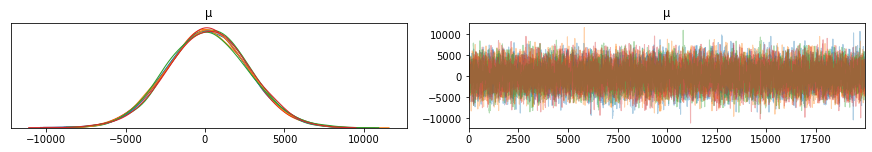

In [47]:
pm.traceplot(trace_two_groups_priorB, var_names=('μ')); 

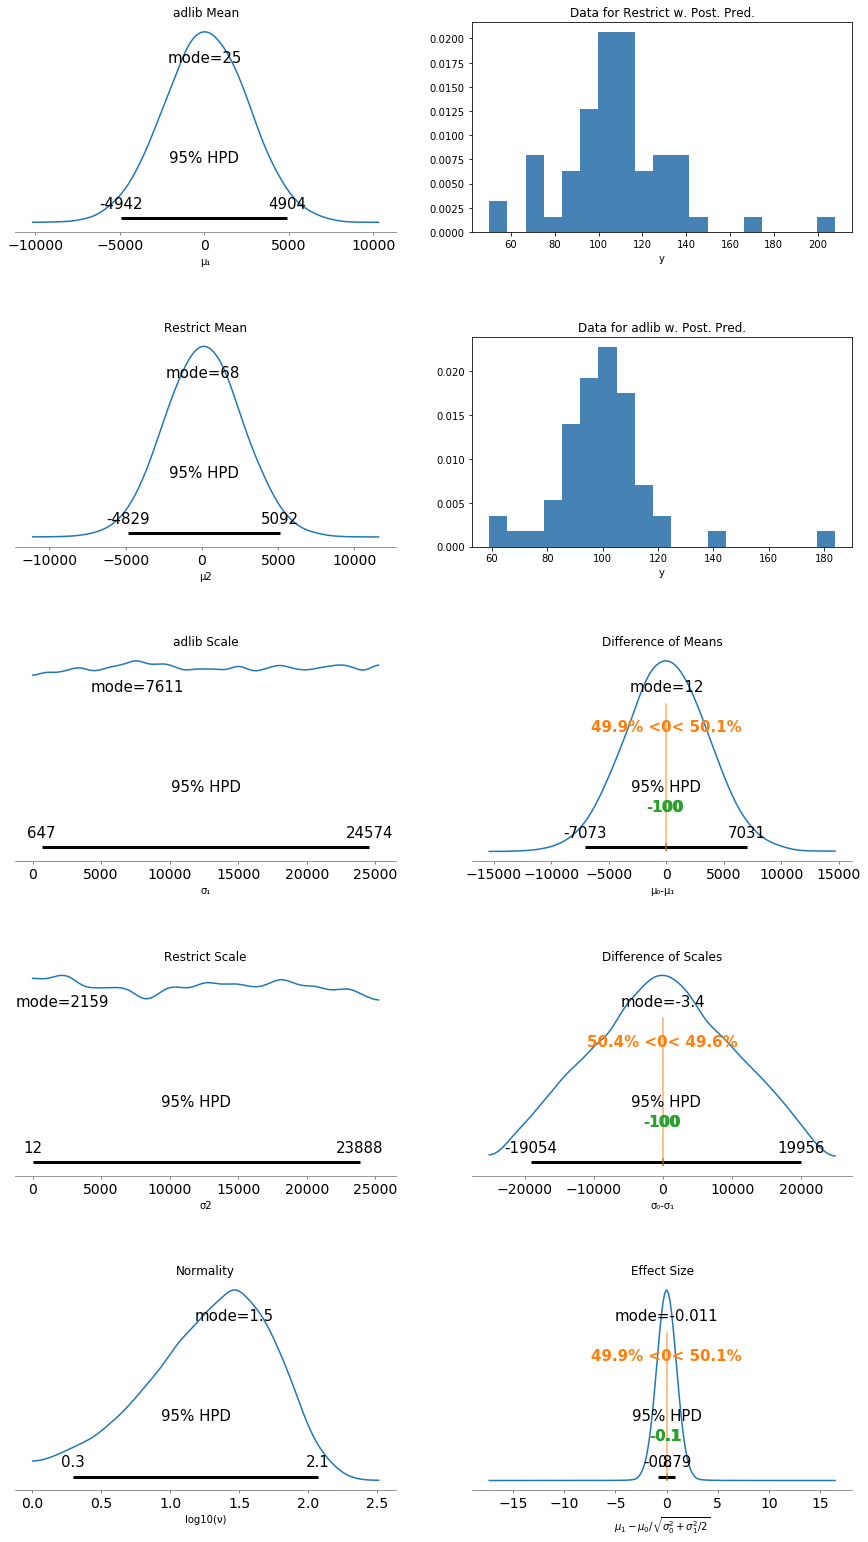

In [29]:
μs11 = np.array([s[0] for s in trace_two_groups_priorB['μ']])
σs12 = np.array([s[0] for s in trace_two_groups_priorB['σ']])

μs21 = np.array([s[1] for s in trace_two_groups_priorB['μ']])
σs22 = np.array([s[1] for s in trace_two_groups_priorB['σ']])

trace1 = np.array([x for x in zip(μs11, σs12)], dtype=[('μ','f4'),('σ','f4')])

trace2 = np.array([x for x in zip(μs21, σs22)], dtype=[('μ','f4'),('σ','f4')])


fig,axs = plt.subplots(nrows=5,ncols=2,figsize=(15,27))

pm.plot_posterior(μs11, ax=axs[0,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(μs21, ax=axs[1,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(σs12, ax=axs[2,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(σs22, ax=axs[3,0], point_estimate='mode', credible_interval=.95)
pm.plot_posterior(trace_two_groups_priorB['log10_ν'], ax=axs[4,0], point_estimate='mode', credible_interval=.95)

weights_S = np.ones_like(y_SmartDrug)/(len(y_SmartDrug)*10)  # Rescale the histogram to look like in the figure
weights_P = np.ones_like(y_Placebo)/(len(y_Placebo)*10)  # Rescale the histogram to look like in the figure
axs[0,1].hist(y_SmartDrug, bins=19, weights=weights_S, color="steelblue")
axs[1,1].hist(y_Placebo, bins=19, weights=weights_P, color="steelblue")


# X = np.linspace(0,200,(200-0)*10)
# Y = lambda mu,sigma: [norm.pdf(x,loc=mu,scale=sigma) for x in X]
# [axs[0,1].plot(X,Y(s['μ'],s['σ']), color='lightsteelblue') for s in trace1[10:]]

pm.plot_posterior(trace_two_groups_priorB['diff_μ'], ax=axs[2,1], point_estimate='mode',
                  ref_val=0, rope=(-100,100), credible_interval=.95)

pm.plot_posterior(trace_two_groups_priorB['diff_σ'], ax=axs[3,1], point_estimate='mode',
                  ref_val=0, rope=(-100,100), credible_interval=.95)

pm.plot_posterior(trace_two_groups_priorB['eff_size'], ax=axs[4,1], point_estimate='mode',
                  ref_val=0, rope=(-0.1,0.1), credible_interval=.95)




fig.subplots_adjust(hspace=0.5)

axs[0,0].set_title('adlib Mean')
axs[0,0].set_xlabel('μ₁')
axs[1,0].set_title('Restrict Mean')
axs[1,0].set_xlabel('μ2')

axs[2,0].set_title('adlib Scale')
axs[2,0].set_xlabel('σ₁')
axs[3,0].set_title('Restrict Scale')
axs[3,0].set_xlabel('σ2')

axs[4,0].set_title('Normality')
axs[4,0].set_xlabel('log10(ν)')

axs[0,1].set_title('Data for Restrict w. Post. Pred.')
axs[0,1].set_xlabel('y')

axs[1,1].set_title('Data for adlib w. Post. Pred.')
axs[1,1].set_xlabel('y')

axs[2,1].set_title('Difference of Means')
axs[2,1].set_xlabel('μ₀-μ₁')

axs[3,1].set_title('Difference of Scales')
axs[3,1].set_xlabel('σ₀-σ₁')

axs[4,1].set_title('Effect Size')
axs[4,1].set_xlabel('$\mu_1-\mu_0/\sqrt{ \sigma^2_0 + \sigma^2_1 / 2}$');